# Introduction
In this example we explore the use case in which the "high-level" API is insufficient: we already have masks generated by some other algorithm.

In the [OcclusionSaliency](OcclusionSaliency.ipynb) example, we showed how to use the "high-level" image classifier black-box API for visual saliency map generation.
This is coined "high-level" because the API does not reveal how the input image and black-box classifier are utilized in generating the saliency heatmap.

In this example use case, however, we already know that we have an external process to generate masks.
In this case, we can utilize a more specific, less-encompassing interface API to generate visual saliency heatmaps: ``GenerateClassifierConfidenceSaliency``.
This instead takes as input computed confidences for the input image, the image masks, and the computed confidences for images over which masks have been applied.
This also takes black-box classifier standardization out of scope since this API does not require invoking the black box: it assumes that the black box has already been invoked, leaving that up to the caller.
Previously formulated black-box classifiers using the `ClassifyImage` interface could of course still be used in this case.

<a id='fig1'></a>
![](figures/gen_classifier_conf_sal_diagram.svg)

The `xaitk-saliency` package additionally provides helper functions for application of masks to an image which can be found in the `xaitk_saliency.utils.masking` module (both batch and streaming versions are available).

Below, we will show mask generation via the superpixel segmentation algorithm ``quickshift`` from the ``scikit-image`` package.

Like in the previous example, this will necessarily require us to define some black-box classification model for us to introspect the saliency of.
We will fill this role here with a PyTorch Imagenet-pretrained ResNet18 network.
This will be wrapped up in an implementation of the `ClassifyImage` interface for input to our "application."
This sub-classing standardizes classifier operation with our API to support the varying ways classification is performed across toolkits and applications.

### Table of Contents
* [Set Up Environment](#Set-Up-Environment-superpixel)
* [The Test Image](#The-Test-Image-superpixel)
* [Black-box Classifier](#Black-box-Classifier-superpixel)
* [Superpixel Mask Generation](#Superpixel-Mask-Generation-superpixel)
* [Generating Saliency Maps](#Generating-Saliency-Maps-superpixel)

### Miscellaneous
License for test image used may be found in 'COCO-LICENSE.txt'.

#### References
1. Zeiler, Matthew D., and Rob Fergus. "Visualizing and understanding convolutional networks." European conference on computer vision. Springer, Cham, 2014.

<br>

To run this notebook in Colab, use the link below:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/XAITK/xaitk-saliency/blob/master/examples/SuperPixelSaliency.ipynb)

# Set Up Environment <a name="Set-Up-Environment-superpixel"></a>

In [1]:
!pip install -qU pip
!pip install -q xaitk-saliency
!pip install -q "torch==1.9.0"
!pip install -q "torchvision==0.10.0"

# The Test Image <a name="The-Test-Image-superpixel"></a>
We will test this application on the following image.
We know that this image contains the ImageNet classes of "boxer" and "tiger cat".

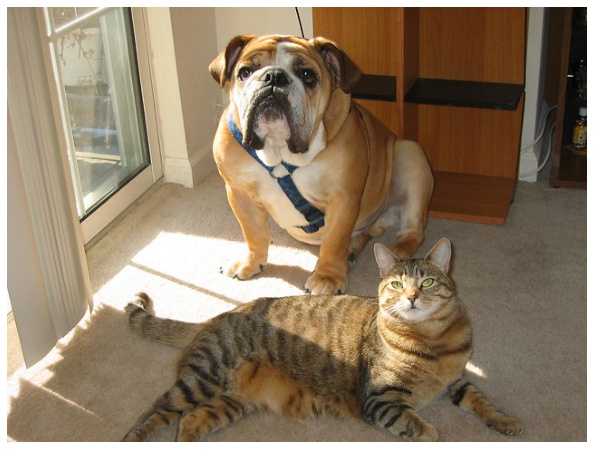

In [2]:
import PIL.Image
import matplotlib.pyplot as plt
import urllib.request


# Use JPEG format for inline visualizations here.
%config InlineBackend.figure_format = "jpeg"


test_image_filename = 'data/catdog.jpg'
urllib.request.urlretrieve('https://farm1.staticflickr.com/74/202734059_fcce636dcd_z.jpg', test_image_filename)
plt.figure(figsize=(12, 8))
plt.axis('off')
_ = plt.imshow(PIL.Image.open(test_image_filename))

# Black-box Classifier <a name="Black-box-Classifier-superpixel"></a>
In this example, we will use a basic PyTorch-based, pretrained ResNet18 model and use its softmax output as classification confidences.
Since this model normally outputs 1000 classes, we will, for simplicity of example, constrain the output to the two classes that we are relevant for our test image.

In [3]:
# Set up our "black box" classifier using PyTorch and it's ImageNet pretrained ResNet18.
# We will constrain the output of our classifier here to the two classes that are relevant
# to our test image for the purposes of this example.
import os
import numpy as np
import torch
import torchvision.models as models
import torchvision.transforms as transforms

CUDA_AVAILABLE = torch.cuda.is_available()


model = models.resnet18(pretrained=True)
model = model.eval()
if CUDA_AVAILABLE:
    model = model.cuda()

# These are some simple helper functions to perform prediction with this model
model_input_size = (224, 224)
model_mean = [0.485, 0.456, 0.406]
model_loader = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(model_input_size), 
    transforms.ToTensor(),
    transforms.Normalize(
        mean=model_mean,
        std=[0.229, 0.224, 0.225]
    ),
])


# Grabbing the class labels associated with this model.
classes_file = "data/imagenet_classes.txt"
if not os.path.isfile(classes_file):
    !wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt -O {classes_file}

f = open(classes_file, "r")
categories = [s.strip() for s in f.readlines()]


# For this test, we will use an image with both a cat and a dog in it.
# Let's only consider the saliency of two class predictions.
sal_class_labels = ['boxer', 'tiger cat']
sal_class_idxs = [categories.index(lbl) for lbl in sal_class_labels]


@torch.no_grad()
def blackbox_classifier(test_image: np.ndarray) -> np.ndarray:
    image_tensor = model_loader(test_image).unsqueeze(0)
    if CUDA_AVAILABLE:
        image_tensor = image_tensor.cuda()
    feature_vec = model(image_tensor)
    # Converting feature extractor output to probabilities.
    class_conf = torch.nn.functional.softmax(feature_vec, dim=1).cpu().detach().numpy().squeeze()
    # Only return the confidences for the focus classes
    return class_conf[sal_class_idxs]


blackbox_fill = np.uint8(np.asarray(model_mean) * 255)

# Superpixel Mask Generation <a name="Superpixel-Mask-Generation-superpixel"></a>
We'll use the [Quick Shift](https://www.robots.ox.ac.uk/~vedaldi/assets/pubs/vedaldi08quick.pdf) segmentation algorithm to generate superpixels that can be used as masks for image perturbation. This technique is also commonly used in other black-box saliency algorithms such as [LIME](https://arxiv.org/abs/1602.04938) and [SHAP](https://arxiv.org/abs/1705.07874). Alternatively, we could create a new `PerturbImage` implementation, similar to the existing `SlidingWindow` and `RISEGrid` approaches.

In [4]:
# Make use of superpixel based mask generation
from skimage.segmentation import quickshift, mark_boundaries

# Load the reference image
ref_image = PIL.Image.open(test_image_filename)
# Generate superpixel segments
segments = quickshift(ref_image, kernel_size=4, max_dist=200, ratio=0.2, random_seed=0)
# Print number of segments
num_segments = len(np.unique(segments))
print("Quickshift number of segments: {}".format(num_segments))

Quickshift number of segments: 212


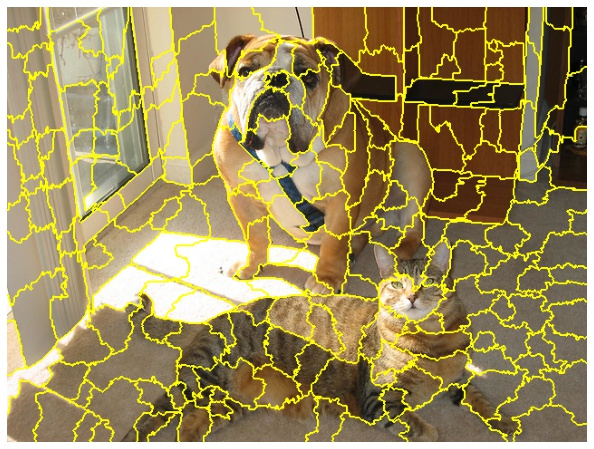

In [5]:
# Visualize the superpixels on the image
plt.figure(figsize=(12, 8))
plt.axis('off')
_ = plt.imshow(mark_boundaries(ref_image, segments))

Next, we'll convert these superpixel segments to binary perturbation masks in preparation for generating the corresponding perturbation images.

In [6]:
pert_masks = np.empty((num_segments, *ref_image.size[::-1]), dtype=bool)
for i in range(num_segments):
    pert_masks[i] = (segments != i)

# Generating Saliency Maps <a name="Generating-Saliency-Maps-superpixel"></a>
We will use the occlusion-based saliency map generation method.
This implements the [above described](#fig1) `GenerateClassifierConfidenceSaliency` interface API.

In [7]:
from xaitk_saliency.impls.gen_classifier_conf_sal.occlusion_scoring import OcclusionScoring

sal_map_generator = OcclusionScoring()

Next, we define a helper function for visualizing the generated results, with defined inputs for the following:
  * the input image
  * black-box classifier
  * perturbation masks
  * saliency map generation API implementation

For the purposes of this tool, let's say that the input blackbox classifier must take in one image and output a 1D vector of per-class confidences (`Callable[[np.ndarray], np.ndarray]`) for simplicity.

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
from typing import Callable, Iterable, Optional, Sequence, Union
from xaitk_saliency import GenerateClassifierConfidenceSaliency
from xaitk_saliency.utils.masking import occlude_image_batch


def app(
    image_filepath: str,
    blackbox_classify: Callable[[np.ndarray], np.ndarray],
    pert_masks: Iterable[np.ndarray],
    sal_map_generator: GenerateClassifierConfidenceSaliency,
    fill: Optional[Union[int, Sequence[int]]] = None,
    vis_mask_examples: bool = True,
):
    # Load the image
    ref_image = np.asarray(PIL.Image.open(image_filepath))
    
    # Remember that we defined our own perturbation masks, and will
    # now use a helper function to generate perturbation images
    pert_imgs = occlude_image_batch(ref_image, pert_masks, fill)
    print(f"Perterbed images: {pert_imgs.shape[0]}")

    # Visualize some example perturbed images before heading into blackbox classification
    if vis_mask_examples:
        n = 4
        print(f"Visualizing {n} random perturbed images...")
        rng = np.random.default_rng(seed=0)
        rng_idx_lst = sorted(rng.integers(0, len(pert_imgs)-1, n))
        plt.figure(figsize=(n*4, 4))
        for i, rnd_i in enumerate(rng_idx_lst):
            plt.subplot(1, n, i+1)
            plt.title(f"pert_imgs[{rnd_i}]")
            plt.axis('off')
            plt.imshow(pert_imgs[rnd_i])

    # For the saliency heatmap generation API we need reference image predictions as well as
    # the predictions for each of the perturbed images.
    ref_preds = blackbox_classify(ref_image)
    print(f"Ref preds: {ref_preds.shape}")
    pert_preds = np.asarray([
        blackbox_classify(pi)
        for pi in pert_imgs
    ])
    print(f"Pert preds: {pert_preds.shape}")

    sal_maps = sal_map_generator(ref_preds, pert_preds, pert_masks)
    print(f"Saliency maps: {sal_maps.shape}")
    
    # Visualize the saliency heat-maps
    sub_plot_ind = len(sal_maps) + 1
    plt.figure(figsize=(12, 6))
    plt.subplot(2, sub_plot_ind, 1)
    plt.imshow(ref_image)
    plt.axis('off')
    plt.title('Test Image')

    # Some magic numbers here to get colorbar to be roughly the same height
    # as the plotted image.
    colorbar_kwargs = {
        "fraction": 0.046*(ref_image.shape[0]/ref_image.shape[1]),
        "pad": 0.04,
    }

    for i, class_sal_map in enumerate(sal_maps):
        print(f"Class {i} saliency map range: [{class_sal_map.min()}, {class_sal_map.max()}]")

        # Positive half saliency
        plt.subplot(2, sub_plot_ind, 2+i)
        plt.imshow(ref_image, alpha=0.7)
        plt.imshow(
            np.clip(class_sal_map, 0, 1),
            cmap='jet', alpha=0.3
        )
        plt.clim(0, 1)
        plt.colorbar(**colorbar_kwargs)
        plt.title(f"Class #{i+1} Pos Saliency")
        plt.axis('off')

        # Negative half saliency
        plt.subplot(2, sub_plot_ind, sub_plot_ind+2+i)
        plt.imshow(ref_image, alpha=0.7)
        plt.imshow(
            np.clip(class_sal_map, -1, 0),
            cmap='jet_r', alpha=0.3
        )
        plt.clim(-1, 0)
        plt.colorbar(**colorbar_kwargs)
        plt.title(f"Class #{i+1} Neg Saliency")
        plt.axis('off')

Finally, we'll call our helper function and visualize the superpixel-based saliency maps.

Perterbed images: 212
Visualizing 4 random perturbed images...
Ref preds: (2,)


/home/brian/.cache/pypoetry/virtualenvs/xaitk-saliency-BlgCxOoJ-py3.7/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Pert preds: (212, 2)
Saliency maps: (2, 480, 640)
Class 0 saliency map range: [-1.0, 0.5285792859603866]
Class 1 saliency map range: [-0.8092064427692536, 1.0]


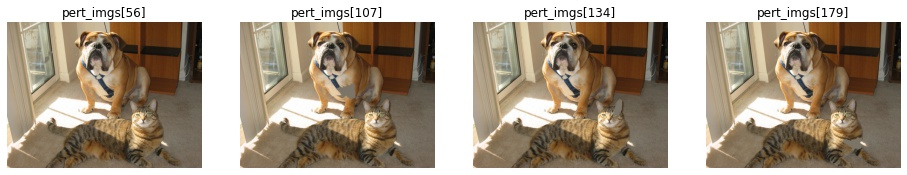

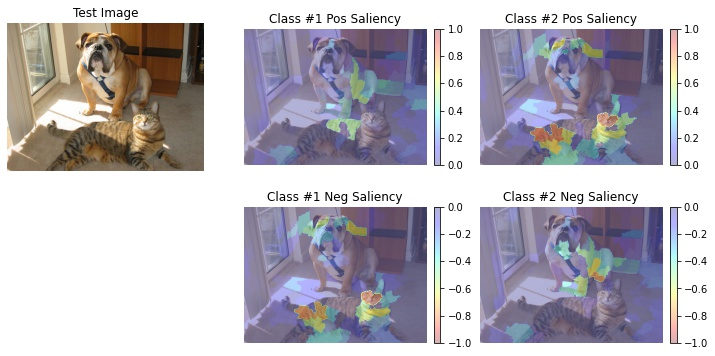

In [9]:
app(
    test_image_filename,
    blackbox_classifier,
    pert_masks,
    sal_map_generator,
    fill=blackbox_fill,
)